In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm

# *Simple univariate example of a normalizing flow*

*Problem description*

Consider the target variable X to be defined as : $$X\sim \mathcal{N}(\mu_X ; \sigma_X)  \text{ with parameters } \mu_X \text{ and } \sigma_X \text{fixed but unknown.} \newline We\ will\ use\ a\ transformation\ such\ that\ T(u)  = A.u + b $$


In [15]:
#The true values unkown to the simulator
mu_x = 3
sigma_x = 0.5
N = 1000
N_test = 10*N
def gen_observations(number_of_observations:int):
    """Generates a tensor of observations, i.e. x drawn from a normal distribution having mu=mu_x and sigma=sigma_x

    Args:
        number_of_observations (int): Number of obs to generates

    Returns:
        torch.tensor : Tensor of observations
    """

    # Number of sample 
  
    #Generating observations from the true distribution
    X_np = np.random.normal(mu_x,sigma_x,number_of_observations)
    X = torch.from_numpy(X_np)
    X.size()[0]

    X = X.reshape(X.size()[0] , 1)
    X = X.type(torch.float32)
    return X
X=gen_observations(N)
X_test = gen_observations(N_test)

In [83]:
torch.FloatTensor(1).uniform_(-1 , 1)

tensor([-0.0483])

In [103]:
class T(nn.Module):
    """Transformation T(u) = A.u + b

    Args:
        None
    """
    
    def __init__(self):
        """Init with a single linear layer, with bias
        """
        super(T, self).__init__()
        self.b = nn.Parameter(torch.FloatTensor(1).uniform_(-1 , 1))
        self.alpha = nn.Parameter(torch.FloatTensor(1).uniform_(-1, 1 ))
       # self.net = nn.Linear(1, 1) #? Voir ce pb de positif ... idée : utiliser w=exp()
    
    def forward(self,u:torch.tensor):
        """Compute the linear transformation

        Args:
            u (torch.tensor)

        Returns:
            A*u + b
        """
        A = torch.exp(self.alpha)
        return A * u + self.b
    
    def L(self, x):
        """Compute the loss as -log(p_est(x))
        """
        A, b = torch.exp(self.alpha), self.b
    
        res = torch.distributions.normal.Normal(b, A).log_prob(x)
        return - res

In [101]:
test = T()
test.parameters()

<generator object Module.parameters at 0x0000022B8ED0E9E0>

In [140]:
n_iter = 600 #Number of iteration
transformation = T() #Instanciation
learning_rate = 1e-2
optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
#optimizer = torch.optim.Adam(transformation.parameters(), learning_rate)

In [141]:
losses = []
estimated_A = []
estimated_b = []
for i in range(n_iter):
    #Computing & saving the loss
    loss = transformation.L(X).mean()
    losses.append(loss.detach().numpy().item())
    #optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Saving parameters for later vizualisation
    A_hat, b_hat = torch.exp(transformation.alpha).item(), transformation.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)

In [142]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1]

sample_mean = torch.mean(X)
sample_sigma = torch.std(X, unbiased=True)

print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final loss = ", losses[-1])

 Sample mean = 2.996152877807617 and b_hat =  2.9958133697509766
 Sample std = 0.50225430727005 and A_hat =  0.5079430937767029
 Final loss =  0.7303668856620789


# Visualisation

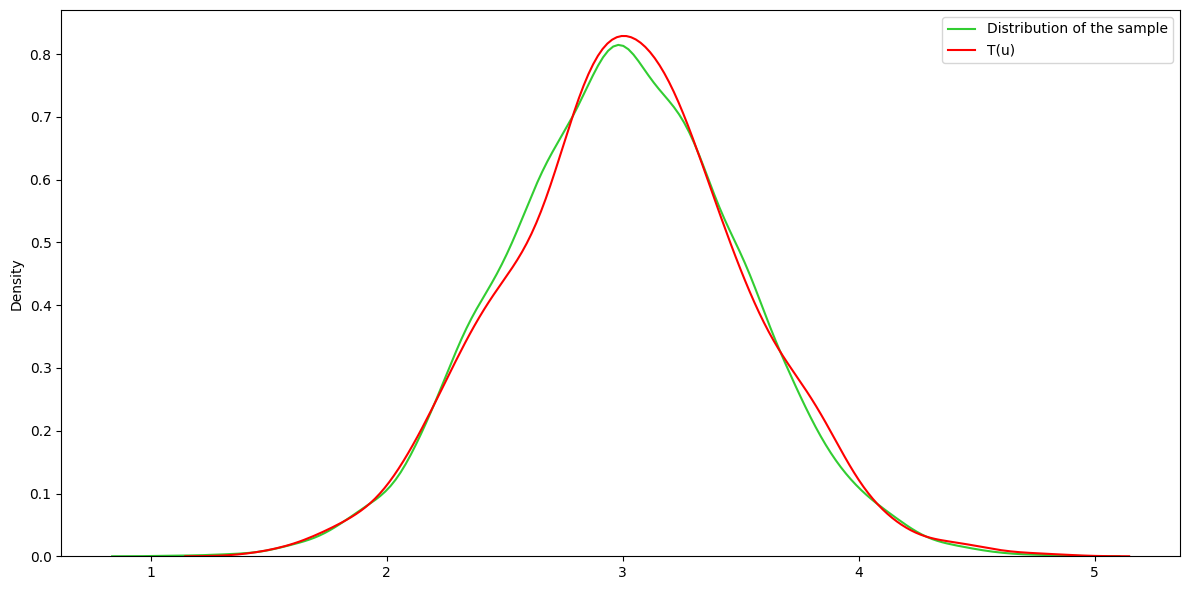

In [143]:
U = torch.distributions.Normal(0, 1).sample((N,1))


fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation.forward(U).detach().squeeze(), ax = ax, color='red', label='T(u)')
ax.legend()
plt.tight_layout()
plt.show()

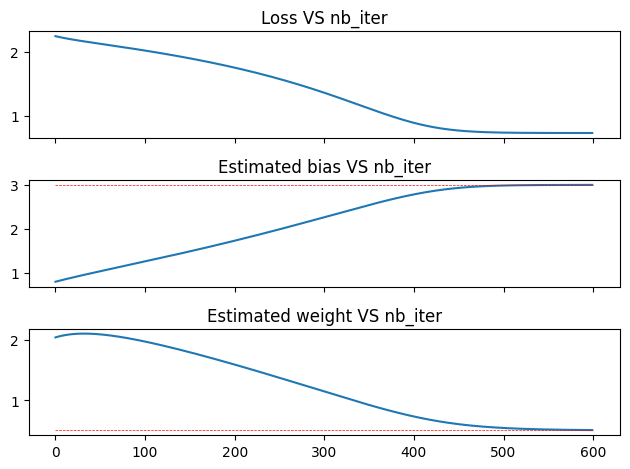

In [144]:
fig, axs = plt.subplots(3, sharex = True)
axs[0].plot(losses)
axs[0].set_title("Loss VS nb_iter")
axs[1].plot(estimated_b)
axs[1].hlines(y=sample_mean,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample mean", linestyles='dashed')
axs[1].set_title("Estimated bias VS nb_iter")
axs[2].plot(estimated_A)
axs[2].hlines(y=sample_sigma,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample std", linestyles='dashed')
axs[2].set_title("Estimated weight VS nb_iter")
fig.tight_layout()

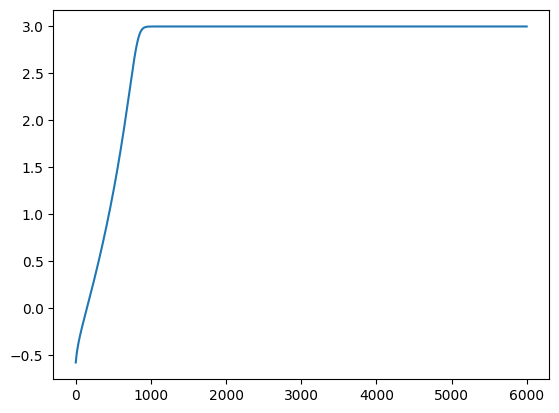

In [110]:
plt.plot(estimated_b)

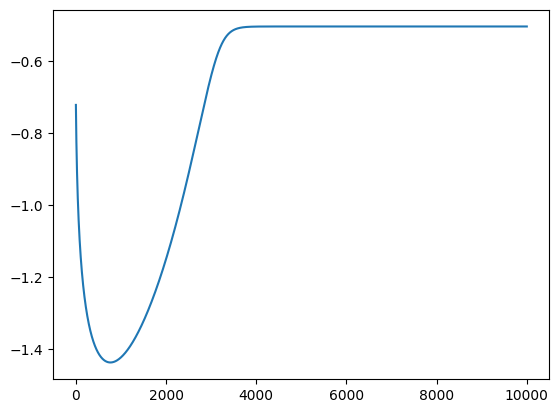

In [24]:
plt.plot(estimated_A)

### Let us compute the loss on a training set

In [145]:
with torch.no_grad():
    loss_t = transformation.L(X_test).mean()
print(loss_t)
losses[-1] # Pas grande différence

tensor(0.7319)


0.7303668856620789

## Effect of sample size, n_iter

### Let us first change the sample size

In [150]:
estimated_A = []
estimated_b = []
sample_sizes = []
n_iter = 600
last_losses = []
sample_means = []
sample_sigmas = []
for sample_size in tqdm(range(10,1000,20)):
    sample_sizes.append(sample_size)
    X = gen_observations(sample_size)
    transformation = T()
    optimizer = torch.optim.SGD(transformation.parameters(),learning_rate)
    #training 
    for i in range(n_iter):
        #Loss
        loss = transformation.L(X).mean()
        #optim
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    last_losses.append(loss.detach().numpy().item())
    A_hat, b_hat = torch.exp(transformation.alpha).item(), transformation.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)
    sample_mean = torch.mean(X)
    sample_sigma = torch.std(X, unbiased=True)
    sample_means.append(sample_mean)
    sample_sigmas.append(sample_sigma)
    

  0%|          | 0/50 [00:00<?, ?it/s]

In [151]:
print(last_losses)

[0.622173547744751, 0.7186641693115234, 0.8157067894935608, 1.4526928663253784, 2.0348386764526367, 1.6889750957489014, 1.9751063585281372, 0.7297510504722595, 1.7161915302276611, 0.741905927658081, 0.6663756370544434, 2.0852177143096924, 0.7516450881958008, 0.6907224059104919, 1.002051830291748, 1.046854019165039, 1.6427854299545288, 0.8519339561462402, 0.7772691249847412, 0.7566178441047668, 0.7194093465805054, 0.7768006920814514, 0.7220718860626221, 0.7095404267311096, 0.7558080554008484, 1.375363826751709, 0.6889994144439697, 1.5673240423202515, 0.7567780017852783, 0.7276370525360107, 2.1198835372924805, 0.7526679039001465, 0.7185198664665222, 0.759747326374054, 1.86967134475708, 2.034522294998169, 0.8024499416351318, 0.7203443050384521, 0.7735581994056702, 0.7093807458877563, 0.9957097768783569, 1.7363024950027466, 1.9750785827636719, 0.7281946539878845, 0.725326418876648, 1.5386654138565063, 0.8754750490188599, 0.7614089250564575, 1.3941211700439453, 1.5790780782699585]


In [152]:
dist_b = abs(np.subtract(sample_means, estimated_b))
dist_A = abs(np.subtract(sample_sigmas, estimated_A))

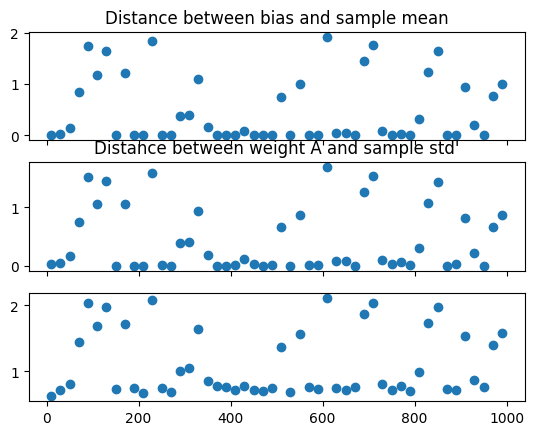

In [154]:
fig, axs = plt.subplots(2, sharex = True)
axs[0].scatter(sample_sizes, dist_b)
#axs[0].set_ylim(-0.5,10)
axs[0].set_title("Distance between bias and sample mean")
axs[1].scatter(sample_sizes, dist_A)
#axs[1].set_ylim(-0.5,10)
axs[1].set_title("Distance between weight A and sample std'")


## What if if X is not gaussian (here chi2)

In [155]:
X_chi = np.random.chisquare(2, N)
X_chi = torch.from_numpy(X_chi)
X_chi = X_chi.reshape(X_chi.size()[0] , 1)
X_chi = X_chi.type(torch.float32)

In [156]:
n_iter = 10000 #Number of iteration
transformation2 = T() #Instanciation
learning_rate = 1e-3
optimizer = torch.optim.SGD(transformation2.parameters(), learning_rate)

In [157]:
losses = []
estimated_A = []
estimated_b = []
for i in range(n_iter):
    #Computing & saving the loss
    loss = transformation2.L(X_chi).mean()
    losses.append(loss.detach().numpy().item())
    #optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Saving parameters for later vizualisation
    A_hat, b_hat = torch.exp(transformation2.alpha).item(), transformation2.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)

In [34]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1]
sample_mean = torch.mean(X_chi)
sample_sigma = torch.std(X_chi, unbiased=True)
print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final loss = ", losses[-1])

 Sample mean = 1.9182143211364746 and b_hat =  1.7875515222549438
 Sample std = 1.9161357879638672 and A_hat =  -1.9350391626358032
 Final loss =  2.0711357593536377


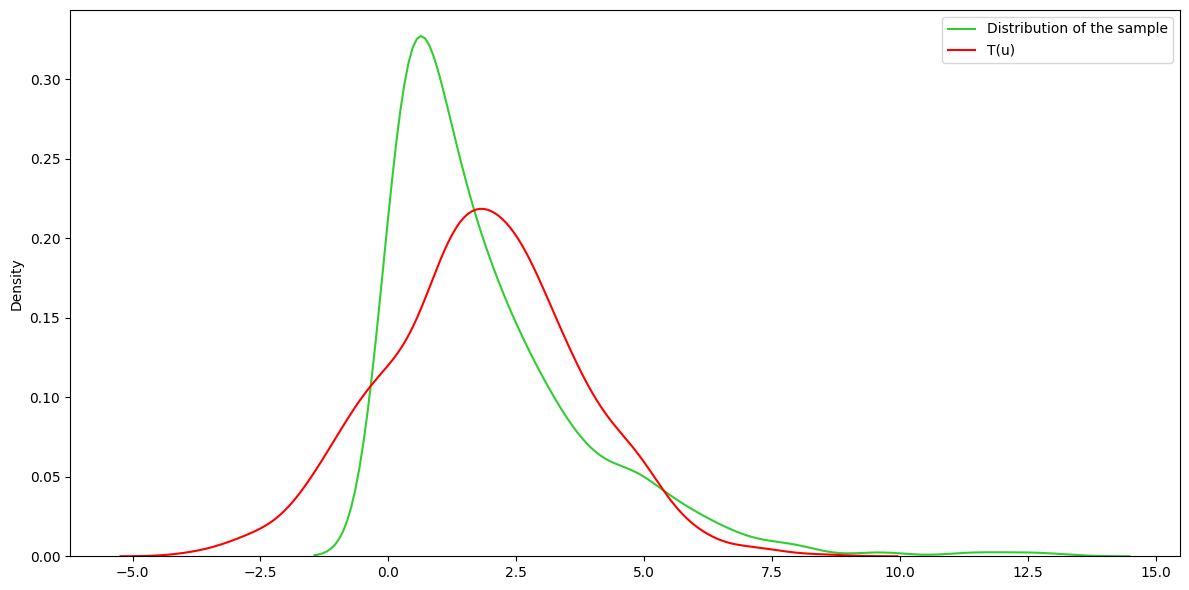

In [158]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X_chi.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation2.forward(U).detach().squeeze(), ax = ax, color='red', label='T(u)')
ax.legend()
plt.tight_layout()
plt.show()